In [36]:
import os
import time

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter

import torchvision

import torchvision.transforms.functional as TF
from PIL import Image

import numpy as np
import unsup_prototype_nongroup_to_group.utils as utils
from unsup_prototype_nongroup_to_group.model import RAE
from unsup_prototype_nongroup_to_group.data import get_dataloader

In [37]:
state = torch.load("/home/patrick/repositories/XIConceptLearning/results/seed3_protos4_2021-02-09_15-13-40/states/01499.pth")
#state = torch.load("/home/patrick/repositories/XIConceptLearning/results/seed3_protos4_wp_2021-02-09_15-01-26/states/01499.pth")
#state = torch.load("/home/patrick/repositories/XIConceptLearning/results/seed3_protos4_2021-02-09_16-25-18/states/01499.pth") # with r2
#state = torch.load("/home/patrick/repositories/XIConceptLearning/results/seed3_protos4_2021-02-09_16-36-51/states/01499.pth") # with r2 without wp

config = state['config']
config['data_path'] = "../data"
model_state_dict = state['model']

In [38]:
data_loader = get_dataloader(config, )

Overriding img_shape and n_prototype_vectors


In [39]:
model = RAE(input_dim=(1, config['img_shape'][0], config['img_shape'][1], config['img_shape'][2]),
                 n_z=config['n_z'], filter_dim=config['filter_dim'],
                 n_proto_vecs=config['prototype_vectors'],
                 train_pw=config['train_weighted_protos'],
                 device=config['device'],
                 agg_type=config['agg_type'])
model.load_state_dict(model_state_dict)
model = model.to(config['device'])

In [40]:
def plot_prototypes(weighted=False):
    # decode prototype vectors
    prototype_vectors = model.prototype_layer.prototype_vectors
    utils.plot_prototypes(model, prototype_vectors, None, 0, config)
    plt.show()

In [41]:
def plot_s_mod(imgs, s_mod=None):

    # plot a few samples with proto recon
    utils.plot_examples(imgs, model, None, 0, config)

    latent_encoding = model.forward_encoder(x)
    dists = model.prototype_layer(latent_encoding.view(-1, model.dim_prototype))
    recon_img, recon_proto, mixed_prototypes = model.forward_decoder(latent_encoding, dists)

    n_cols = 2
    examples_to_show = len(imgs)
    # decoded image
    encoded = model.enc.forward(imgs)
        
    prototype_vectors = model.prototype_layer.prototype_vectors
    
    # decoded softmin weighted prototype
    softmin = torch.nn.Softmin(dim=1)
    p_z = list_of_distances(encoded.view(-1, model.input_dim_prototype), prototype_vectors, norm='l2')
    # std = (config['training_epochs'] - e) / config['training_epochs']
    # p_z += torch.normal(torch.zeros_like(p_z), std)

    if s_mod == None:
        s = softmin(p_z)
    else:
        s = s_mod
    vs = s.detach().cpu().numpy()
    for v in vs:
        print(v / np.sum(v))
    prototype_vectors = torch.mul(model.weights_prototypes, prototype_vectors)
    print(model.weights_prototypes)
    softmin_prototype_vector = s@prototype_vectors
    decoded_proto_softmin = model.dec.forward(softmin_prototype_vector.reshape(encoded.shape))

    decoded_proto_softmin = decoded_proto_softmin.detach().cpu()
    # compare original images to their reconstructions
    n_rows = 2
    f, a = plt.subplots(n_rows, examples_to_show, figsize=(examples_to_show, n_rows))

    a[0][0].text(0,-2, s='recon softmin proto', fontsize=10)
    a[1][0].text(-1,-0.6, s='softmin weights', fontsize=10)

    for i in range(examples_to_show):

        a[0][i].imshow(decoded_proto_softmin[i].reshape(config['img_shape']).permute(1,2,0).squeeze(), 
                        cmap='gray',
                        interpolation='none')
        a[0][i].axis('off')

        n_cols_proto = n_cols
        n_rows_proto = config['n_prototype_vectors'] // n_cols + 1 if config['n_prototype_vectors'] % n_cols != 0 else config['n_prototype_vectors'] // n_cols

        weights_i = np.zeros((n_rows_proto * n_cols_proto, ))
        weights_i[0:len(s[i])] = s[i].detach().cpu()
        weights_i = weights_i.reshape(n_rows_proto,n_cols_proto)
        weights_i = 1 - weights_i

        a[1][i].imshow(weights_i,
                        interpolation='none')
        a[1][i].axis('off')

    plt.show()

In [42]:
def mod_s_random(imgs, n_combs_min=2, n_combs_max=4):
    examples_to_show = len(imgs)
    prototype_vectors = model.prototype_layer.prototype_vectors
    encoded = model.enc.forward(imgs[:examples_to_show])
    s_tmp = list_of_distances(encoded.view(-1, model.input_dim_prototype), prototype_vectors, norm='l2')
    
    s_mod = torch.zeros_like(s_tmp)
    for i in range(s_mod.shape[0]):
        n_mod = np.random.randint(n_combs_min,n_combs_max+1)
        for j in range(n_mod):
            idx = np.random.randint(0,s_mod.shape[1])
            s_mod[i][idx] = 1/n_mod
    return s_mod

In [43]:
def mod_s_custom(imgs, combs=[[0,1],[1,0]]):
    prototype_vectors = model.prototype_layer.prototype_vectors
    encoded = model.enc.forward(imgs)
    s_tmp = list_of_distances(encoded.view(-1, model.input_dim_prototype), prototype_vectors, norm='l2')
    
    s_mod = torch.zeros_like(s_tmp)
    for i in range(len(combs)):
        for j in range(len(combs[i])):
            s_mod[i][combs[i][j]] = 1/len(combs[i])
    return s_mod

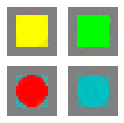

In [44]:
plot_prototypes()

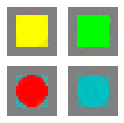

In [45]:
plot_prototypes(weighted=True)

In [46]:
x = data_loader.dataset.tensors[0].detach().numpy().tolist()
y = data_loader.dataset.tensors[1].detach().numpy().tolist()
y_set = np.unique(y,axis=0).tolist()
x_set = []
for u in y_set:
    x_set.append(x[y.index(u)])
x_set = torch.Tensor(x_set)
imgs = x_set.to(config['device'])

[2.8722879e-01 7.0968729e-01 3.0718995e-03 1.2035108e-05]
[7.8916609e-01 1.7575030e-01 3.4922730e-02 1.6088363e-04]
[6.5293387e-02 3.0736887e-04 9.3342030e-01 9.7896764e-04]
[3.7171767e-04 1.4851885e-06 1.1080831e-03 9.9851876e-01]
[7.7394776e-02 9.2227960e-01 3.2445096e-04 1.2143477e-06]
[8.5417593e-01 6.7035347e-02 7.8431167e-02 3.5760197e-04]
[0.19760124 0.00158441 0.79960346 0.00121087]
[3.8508163e-04 1.5385718e-06 1.1523872e-03 9.9846101e-01]
Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

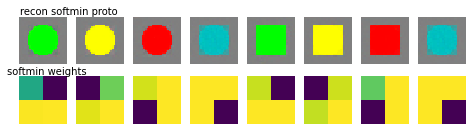

In [47]:
plot_s_mod(imgs, None)

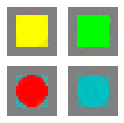

[1. 0. 0. 0.]
[0. 1. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]
[1. 0. 0. 0.]
[0. 1. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]
Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]], device='cuda:0')


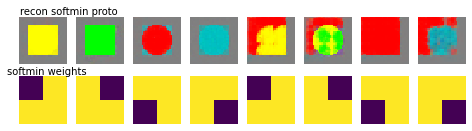

In [48]:
plot_prototypes(weighted=True)
# custom combinations with list of indices list
s_mod = mod_s_custom(imgs, [[0],[1],[2],[3], [0,0],[1,1],[2,2],[3,3]])
plot_s_mod(imgs, s_mod)

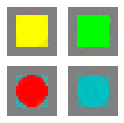

[0.5 0.  0.  0.5]
[0.  0.5 0.  0.5]
[0.  0.  0.5 0.5]
[0. 0. 0. 1.]
[1. 0. 0. 0.]
[0. 1. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]
Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]], device='cuda:0')


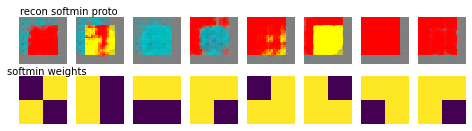

In [49]:
plot_prototypes(weighted=True)
# custom combinations with list of indices list
s_mod = mod_s_custom(imgs, [[0,3],[1,3],[2,3],[3,3], [0,0,0,0],[1,1,1,1],[2,2,2,2],[3,3,3,3]])
plot_s_mod(imgs, s_mod)


In [50]:
# prototype_vectors = model.prototype_layer.prototype_vectors
# combs_all = []
# for i in range(prototype_vectors.shape[0]):
#     for j in range(prototype_vectors.shape[0]):
#         combs_all += [[i,j]]